# 設定ファイル読み込み

In [8]:
from src.utils.config import load_config
config = load_config('config','config')

In [9]:
from omegaconf import OmegaConf
OmegaConf.to_container(config, resolve=True)

{'model': {'name': 'AutoEncoder',
  'instance': {'_target_': 'src.models.AutoEncoder.model.AutoEncoder'},
  'optimizer': {'_target_': 'torch.optim.Adam', 'lr': 1e-05},
  'net': {'hidden_size': [16, 8, 4],
   'z_dim': 4,
   'dropout': 0,
   'batch_size': 32},
  'data': {'window_size': 1,
   'feature_cols': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
   'input_vec': 'features'}},
 'data': {'name': 'EEG',
  'dataset_class': 'TSDataset',
  'target_type': 'generative',
  'input_vec': 'features',
  'num_workers': 0,
  'file_type': 'file',
  'feature_cols': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  'window_size': 1,
  'train': {'batch_size': 32,
   'slide_step': 1,
   'file': 'EEG Eye State.arff',
   'split_size': 0.7},
  'val': {'batch_size': 32,
   'slide_step': 1,
   'file': 'EEG Eye State.arff',
   'split_size': 0.3},
  'test': {'batch_size': 1, 'slide_step': 1, 'file': 'EEG Eye State.arff'}},
 'logger': {'_target_': 'pytorch_lightning.loggers.MLFlowLogger',
  'experiment_name

# データファイル読み込み

正規化処理をしていなかった....

In [3]:
from src.utils.dataset import DataModule
dm = DataModule(config.data)

In [4]:
dm.setup()

(x,y): (4706, 1, 14) (4706, 1, 14)
(x,y): (2017, 1, 14) (2017, 1, 14)
(x,y): (14980, 1, 14) (14980, 1, 14)


# AnomalyDetector の定義・訓練

## 定義

In [10]:
from src import AnomalyDetector
ad = AnomalyDetector(config)

AutoEncoder(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=14, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=8, out_features=4, bias=True)
      (7): ReLU()
      (8): Dropout(p=0, inplace=False)
    )
    (z): Linear(in_features=4, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=4, out_features=8, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=8, out_features=16, bias=True)
      (7): ReLU()
      (8): Dropout(p=0, inplace=False)
    )
    (output): Linear(in_features=16, out_features=14, bias=True)
  )
)


## 訓練(初回)

In [12]:
ad.train(dm=dm, max_epochs=10)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type       | Params
-------------------------------------------------
0  | encoder          | Encoder    | 432   
1  | encoder.hidden   | ModuleList | 412   
2  | encoder.hidden.0 | Linear     | 240   
3  | encoder.hidden.1 | ReLU       | 0     
4  | encoder.hidden.2 | Dropout    | 0     
5  | encoder.hidden.3 | Linear     | 136   
6  | encoder.hidden.4 | ReLU       | 0     
7  | encoder.hidden.5 | Dropout    | 0     
8  | encoder.hidden.6 | Linear     | 36    
9  | encoder.hidden.7 | ReLU       | 0     
10 | encoder.hidden.8 | Dropout    | 0     
11 | encoder.z        | Linear     | 20    
12 | decoder          | Decoder    | 442   
13 | decoder.hidden   | ModuleList | 204   
14 | decoder.hidden.0 | Linear     | 20    
15 | decoder.hidden.1 | ReLU       | 0     
16 | decoder.hidden.2 | Dropout    | 0     
17 | decoder.hidden.3 | Linear     | 40    

Validation sanity check: |                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                 | 0/? [00:00<?, ?it/s]

Saving latest checkpoint...


## 訓練(再開)

### 上の訓練の続きで実行する場合
max_epochs は 再開訓練 epoch数を継続するため、最低でも n_epoch < max_epoch であることが必要

In [7]:
ad.train_from(n_epoch='last', max_epochs=200)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 432   
1 | decoder | Decoder | 442   
------------------------------------
874       Trainable params
0         Non-trainable params
874       Total params


Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Saving latest checkpoint...


### 既存の保存モデルから再開する場合

In [8]:
ad.train_from(n_epoch='last', max_epochs=200, save_dir='./mlruns', experiment_id = '1', run_id = '76485829140d43a29b902b6af68d3d9e', dm=dm)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 432   
1 | decoder | Decoder | 442   
------------------------------------
874       Trainable params
0         Non-trainable params
874       Total params


Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Saving latest checkpoint...


# 評価

## モデルの読み込み

In [8]:
ad.model_checkpoint.best_model_path

'C:\\Users\\k_shinoda\\Program\\PyTorchLightning_Hydra_MLFlow_Optuna\\mlruns\\1\\e73318ace7a74682a7f10780a8100bdb\\artifacts\\models\\model-epoch=133.ckpt'

'last.ckpt'を読み込むときには

In [6]:
ad.load_ckpt(n_epoch='last', save_dir='./mlruns', experiment_id = '1', run_id = 'cd6af8e8eb344b01bb1121582b3f8597')

C:\Users\k_shinoda\anaconda3\envs\pytorch-lightning\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


再開する epoch を指定する(例 epoch=29)場合には

In [ ]:
ad.load_ckpt(n_epoch=29, save_dir='./mlruns', experiment_id = '1', run_id = 'cd6af8e8eb344b01bb1121582b3f8597')

## 異常度の取得

In [16]:
len(dm.val_dataloader())

18

In [5]:
len(dm.test_dataloader())

14917

In [9]:
ad.trainer.resume_from_checkpoint

'C:\\Users\\k_shinoda\\Program\\PyTorchLightning_Hydra_MLFlow_Optuna\\mlruns\\1\\e73318ace7a74682a7f10780a8100bdb\\artifacts\\models\\model-epoch=29.ckpt'

In [10]:
anomaly_scores = ad.get_anomaly_scores(dm=dm)

Testing: |                                                                                       | 0/? [00:00<…

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0010), 'val_loss': tensor(0.0711)}
--------------------------------------------------------------------------------


In [11]:
len(anomaly_scores)

14980

In [11]:
import pandas as pd
df = pd.DataFrame(anomaly_scores)

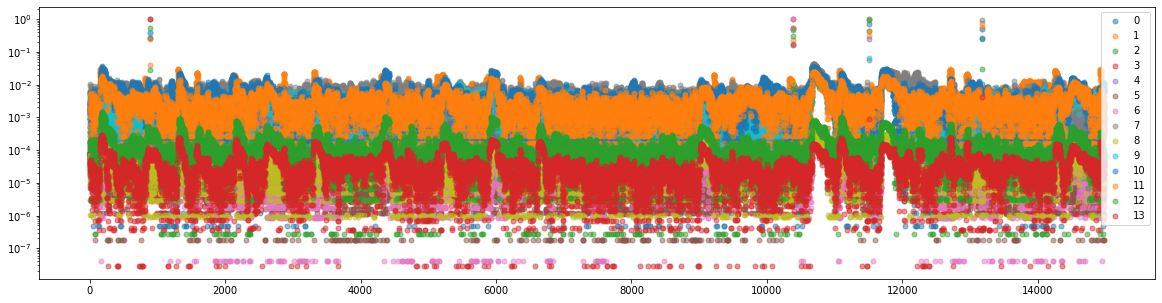

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
df.plot.line(ax=ax, style='o',ms=5, alpha=.5)
ax.semilogy()
#df.rolling(50, center=True).mean().plot.line(ax=ax, style='g--', alpha=.5)
#ax2 = ax.twinx()
#pd.read_csv('./data/dsc_2019/predict/data01_predict.csv').plot(ax=ax2,style='--', alpha=.3, label='observe')
#fig.savefig('tmp.svg')
plt.show()

In [13]:
from scipy.io import arff
import pandas as pd
label, _ = arff.loadarff('data/EEG/EEG Eye State.arff')
label = pd.DataFrame(label).values

In [14]:
label = label[:,[-1]]
label = label.astype(int)

In [22]:
len(label)

14980

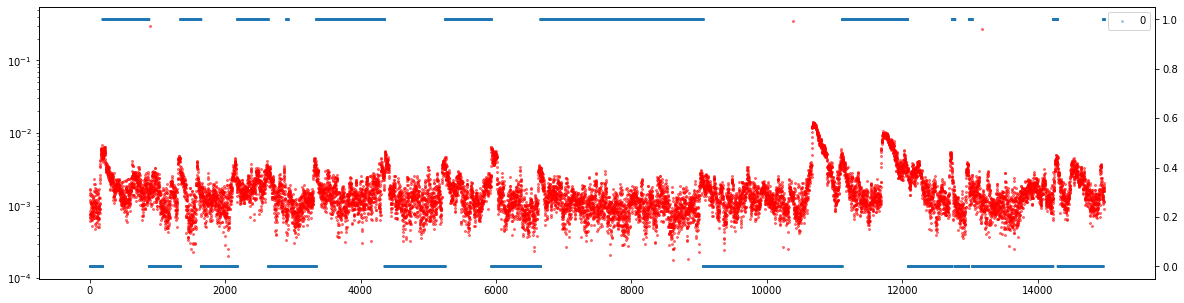

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
df.mean(axis=1).plot.line(ax=ax, style='ro',ms=2, alpha=.5)
#df.rolling(50, center=True).mean().plot.line(ax=ax, style='g--', alpha=.5)
ax.semilogy()
ax2 = ax.twinx()
pd.DataFrame(label).plot(ax=ax2, style='o', ms=2, alpha=.3, label='observe')
#fig.savefig('tmp.svg')
plt.show()

# 実験ログの確認

上記プログラムを動作させるうえですでに mlflow をインストールしていると思われるので以下を実行
```
 % cd <project folder>
 % mlflow ui
```
その際、プロジェクトフォルダ直下以外に保存フォルダ(mlruns)を指定した場合(例: ../mlruns)には以下のように実行しないと、artficts に保存したフォルダやモデルが表示されない...
```
 % cd <project folder>
 % mlflow ui --backend-store-uri ../mlruns -p <port>
```
起動後は、デフォルト設定のままであれば、ブラウザで http://localhost:5000/ でアクセス可能